<a href="https://colab.research.google.com/github/theorignalmapdcodex/aipi590_i-8_aa-ap/blob/main/notebooks/adversarial_patch_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

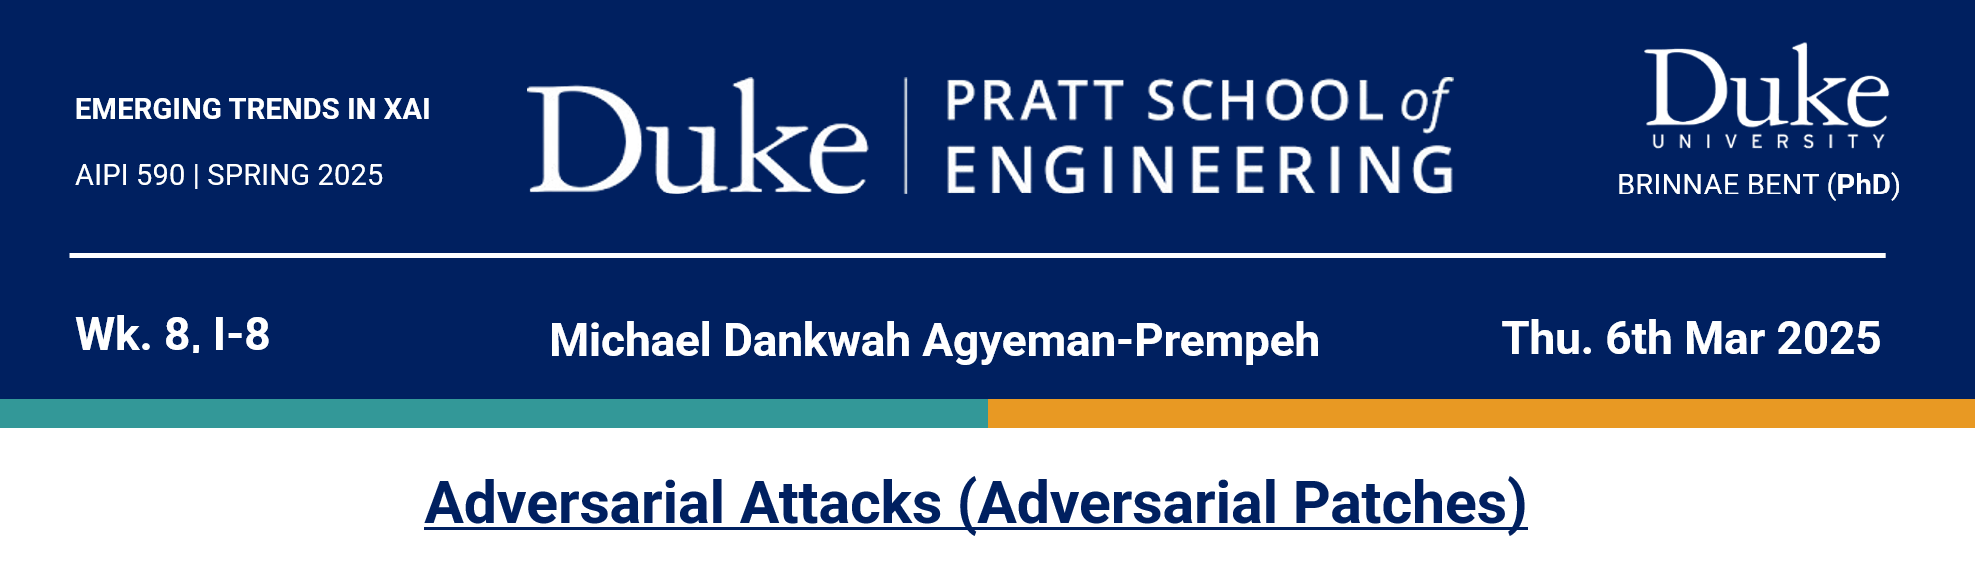

### 🔃 **Downloading Files Externally [the dataset of use & the requirements.txt file] for Processing as well as Package Installation (With the Idea of Sharing to Others)**

In [8]:
!pip install -U gdown  # Installing gdown if not already installed

# A - Grabbing actual file IDs from the Google Drive shared links
reqtxt_file_id = "1U4V_9N1I4msCNDgi39MpMfEDtgG-xVko"

# B - Saving file to local varible for ease of use
reqtxt_output_file = "requirements.txt"

# C - Download the requirements file
!gdown "https://drive.google.com/uc?id={reqtxt_file_id}" -O {reqtxt_output_file}

Downloading...
From: https://drive.google.com/uc?id=1U4V_9N1I4msCNDgi39MpMfEDtgG-xVko
To: /content/requirements.txt
100% 93.0/93.0 [00:00<00:00, 457kB/s]


>#### 🔗 **1. GitHub Link:**
- Click [here](https://github.com/theorignalmapdcodex/aipi590_i-8_aa-ap/blob/main/notebooks/adversarial_patch_generation.ipynb) to access the *GitHub repository .ipynb* file for this assignment.

##🥅 **Assignment Goal:**
### *The goal of this assignment is to design and implement an effective adversarial patch capable of fooling a pre-trained ResNet34 image classification model. I will leverage a class from the ImageNet dataset to create the patch. The project will demonstrate my understanding by producing a physical patch that successfully alters the model's predictions in a live test showcasing creative application of adversarial techniques.*


--------------------------------------------------------------------------------

In [9]:
# To ignore warnings for code output to look clean
import warnings
warnings.filterwarnings("ignore")

In [10]:
# NB: You can choose to un-comment and clone if not, the code book should run fine from 'gdown' approach
# import os

# # Remove Colab default sample_data if it exists
# if os.path.exists("./sample_data"):
#     !rm -r ./sample_data

# # Clone GitHub files to colab workspace
# repo_name = f'{aipi590_i-5_edl}'

# # Check if the repo already exists
# if not os.path.exists("/content/" + repo_name):
#     git_path = f'{https://github.com/theorignalmapdcodex/aipi590_i-5_edl.git}'
#     !git clone "{git_path}"
# else:
#     print(f"{aipi590_i-5_edl} already exists.")

# # Change working directory to location of notebook
# path_to_notebook = os.path.join("/content/" + aipi590_i-5_edl)
# %cd "{path_to_notebook}"
# %ls

## 📚 **I. Libraries & Packages Installation**

Before I proceed to developing any `saliency map` on my test images, `zebras`, let's first install the right libraries and packages.

In [11]:
#Install the requirements for this package and included in requirements.txt file for the purposes of working on Colab independently
!pip install -r requirements.txt

In [12]:
#----Standard libraries----#
import os
import json
import math
import time
import numpy as np
import scipy.linalg

##----Imports for plotting----##
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.set()

###----Progress bar----###
from tqdm.notebook import tqdm

import urllib.request
from urllib.error import HTTPError
import zipfile

####----PyTorch----####
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms
# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint


##🛣️ **III. Approach:**
### To ensure reproducible and efficient patch creation for our ResNet34 attack, we'll first define dataset and model paths, set a consistent random seed, and then select the optimal computational device, prioritizing GPU acceleration if available.


In [ ]:
# Path to the folder where the datasets are/should be downloaded (e.g. MNIST)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/tutorial10"

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

Downloading the TinyImageNet dataset and pretrained patches from a GitHub repository and unzipping the files.

In [ ]:
# Github URL where the dataset is stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial10/"
# Files to download
pretrained_files = [(DATASET_PATH, "TinyImageNet.zip"), (CHECKPOINT_PATH, "patches.zip")]
# Create checkpoint path if it doesn't exist yet
os.makedirs(DATASET_PATH, exist_ok=True)
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for dir_name, file_name in pretrained_files:
    file_path = os.path.join(dir_name, file_name)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)
        if file_name.endswith(".zip"):
            print("Unzipping file...")
            with zipfile.ZipFile(file_path, 'r') as zip_ref:
                zip_ref.extractall(file_path.rsplit("/",1)[0])

Loading the model, ResNet34

In [ ]:
# Load CNN architecture pretrained on ImageNet
os.environ["TORCH_HOME"] = CHECKPOINT_PATH
pretrained_model = torchvision.models.resnet34(weights='IMAGENET1K_V1')
pretrained_model = pretrained_model.to(device)

# No gradients needed for the network
pretrained_model.eval()
for p in pretrained_model.parameters():
    p.requires_grad = False

In [ ]:
# Mean and standard deviation for normalizing images using the standard ImageNet statistics
NORM_MEAN = np.array([0.485, 0.456, 0.406])  # Mean RGB values for ImageNet
NORM_STD = np.array([0.229, 0.224, 0.225])   # Standard deviation for ImageNet

# Transformation pipeline for preprocessing the images:
# Converts the images to tensors and normalizes them using ImageNet statistics.
plain_transforms = transforms.Compose([
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=NORM_MEAN, std=NORM_STD)  # Normalize using ImageNet mean and std
])

# Load the TinyImageNet dataset and create a DataLoader for batching and shuffling data.
imagenet_path = os.path.join(DATASET_PATH, "TinyImageNet/")
assert os.path.isdir(imagenet_path), f"Could not find the ImageNet dataset at expected path \"{imagenet_path}\". " + \
                                     f"Ensure that the dataset is downloaded, or update the {DATASET_PATH=} variable."
# Loading the dataset using ImageFolder, which assumes images are organized by class folders.
dataset = torchvision.datasets.ImageFolder(root=imagenet_path, transform=plain_transforms)

# DataLoader to iterate over the dataset in batches of 32 images.
data_loader = data.DataLoader(dataset, batch_size=32, shuffle=False, drop_last=False, num_workers=8)

# Load label names from a JSON file for mapping class indices to their corresponding labels.
with open(os.path.join(imagenet_path, "label_list.json"), "r") as f:
    label_names = json.load(f)

# Function to get the index of a label (class name) from the list of label names.
def get_label_index(lab_str):
    assert lab_str in label_names, f"Label \"{lab_str}\" not found. Check the spelling of the class."
    return label_names.index(lab_str)

Verifing the performance of the model before adversirial attack.

In [ ]:
def eval_model(dataset_loader, img_func=None):
    tp, tp_5, counter = 0., 0., 0.
    for imgs, labels in tqdm(dataset_loader, desc="Validating..."):
        imgs = imgs.to(device)
        labels = labels.to(device)
        if img_func is not None:
            imgs = img_func(imgs, labels)
        with torch.no_grad():
            preds = pretrained_model(imgs)
        tp += (preds.argmax(dim=-1) == labels).sum()
        tp_5 += (preds.topk(5, dim=-1)[1] == labels[...,None]).any(dim=-1).sum()
        counter += preds.shape[0]
    acc = tp.float().item()/counter
    top5 = tp_5.float().item()/counter
    print(f"Top-1 error: {(100.0 * (1 - acc)):4.2f}%")
    print(f"Top-5 error: {(100.0 * (1 - top5)):4.2f}%")
    return acc, top5

In [ ]:
_ = eval_model(data_loader)

## ⚙️ **IV. Functions to Support Implementation**

In [ ]:
def show_prediction(img, label, pred, K=5, adv_img=None, noise=None):

    if isinstance(img, torch.Tensor):
        # Tensor image to numpy
        img = img.cpu().permute(1, 2, 0).numpy()
        img = (img * NORM_STD[None,None]) + NORM_MEAN[None,None]
        img = np.clip(img, a_min=0.0, a_max=1.0)
        label = label.item()

    # Plot on the left the image with the true label as title.
    # On the right, have a horizontal bar plot with the top k predictions including probabilities
    if noise is None or adv_img is None:
        fig, ax = plt.subplots(1, 2, figsize=(10,2), gridspec_kw={'width_ratios': [1, 1]})
    else:
        fig, ax = plt.subplots(1, 5, figsize=(12,2), gridspec_kw={'width_ratios': [1, 1, 1, 1, 2]})

    ax[0].imshow(img)
    ax[0].set_title(label_names[label])
    ax[0].axis('off')

    if adv_img is not None and noise is not None:
        # Visualize adversarial images
        adv_img = adv_img.cpu().permute(1, 2, 0).numpy()
        adv_img = (adv_img * NORM_STD[None,None]) + NORM_MEAN[None,None]
        adv_img = np.clip(adv_img, a_min=0.0, a_max=1.0)
        ax[1].imshow(adv_img)
        ax[1].set_title('Adversarial')
        ax[1].axis('off')
        # Visualize noise
        noise = noise.cpu().permute(1, 2, 0).numpy()
        noise = noise * 0.5 + 0.5 # Scale between 0 to 1
        ax[2].imshow(noise)
        ax[2].set_title('Noise')
        ax[2].axis('off')
        # buffer
        ax[3].axis('off')

    if abs(pred.sum().item() - 1.0) > 1e-4:
        pred = torch.softmax(pred, dim=-1)
    topk_vals, topk_idx = pred.topk(K, dim=-1)
    topk_vals, topk_idx = topk_vals.cpu().numpy(), topk_idx.cpu().numpy()
    ax[-1].barh(np.arange(K), topk_vals*100.0, align='center', color=["C0" if topk_idx[i]!=label else "C2" for i in range(K)])
    ax[-1].set_yticks(np.arange(K))
    ax[-1].set_yticklabels([label_names[c] for c in topk_idx])
    ax[-1].invert_yaxis()
    ax[-1].set_xlabel('Confidence')
    ax[-1].set_title('Predictions')

    plt.show()
    plt.close()

<mark>[OPTIONAL]</mark> Visualizing few images below to test the model (prior to adversial attack)

In [ ]:
exmp_batch, label_batch = next(iter(data_loader))
with torch.no_grad():
    preds = pretrained_model(exmp_batch.to(device))
for i in range(1,17,5):
    show_prediction(exmp_batch[i], label_batch[i], preds[i])

For each image in the batch, I'll randomly choose a position and overlay the adversarial patch, ensuring each gets its own unique placement.

In [ ]:
def place_patch(img, patch):
    for i in range(img.shape[0]):
        h_offset = np.random.randint(0,img.shape[2]-patch.shape[1]-1)
        w_offset = np.random.randint(0,img.shape[3]-patch.shape[2]-1)
        img[i,:,h_offset:h_offset+patch.shape[1],w_offset:w_offset+patch.shape[2]] = patch_forward(patch)
    return img

I will then scale the patch's pixel values to fit within a normal image's range.

In [ ]:
TENSOR_MEANS, TENSOR_STD = torch.FloatTensor(NORM_MEAN)[:,None,None], torch.FloatTensor(NORM_STD)[:,None,None]
def patch_forward(patch):
    # Map patch values from [-infty,infty] to ImageNet min and max
    patch = (torch.tanh(patch) + 1 - 2 * TENSOR_MEANS) / (2 * TENSOR_STD)
    return patch

Test the patch's success by placing it randomly on images, checking if the model predicts the target class (and if it's in the top 5), then report accuracy.

In [ ]:
def eval_patch(model, patch, val_loader, target_class):
    model.eval()
    tp, tp_5, counter = 0., 0., 0.
    with torch.no_grad():
        for img, img_labels in tqdm(val_loader, desc="Validating...", leave=False):
            # For stability, place the patch at 4 random locations per image, and average the performance
            for _ in range(4):
                patch_img = place_patch(img, patch)
                patch_img = patch_img.to(device)
                img_labels = img_labels.to(device)
                pred = model(patch_img)
                tp += torch.logical_and(pred.argmax(dim=-1) == target_class, img_labels != target_class).sum()
                tp_5 += torch.logical_and((pred.topk(5, dim=-1)[1] == target_class).any(dim=-1), img_labels != target_class).sum()
                counter += (img_labels != target_class).sum()
    acc = tp/counter
    top5 = tp_5/counter
    return acc, top5

Iteratively optimize the patch by placing it randomly on training images, guiding the model towards the target class via Stochastic Gradient Descent (SGD), and then evaluate the patch's performance on validation images.

In [ ]:
def patch_attack(model, target_class, patch_size=64, num_epochs=5):
    train_set, val_set = torch.utils.data.random_split(dataset, [4500, 500])
    train_loader = data.DataLoader(train_set, batch_size=32, shuffle=True, drop_last=True, num_workers=8)
    val_loader = data.DataLoader(val_set, batch_size=32, shuffle=False, drop_last=False, num_workers=4)

    # Create parameter and optimizer
    if not isinstance(patch_size, tuple):
        patch_size = (patch_size, patch_size)
    patch = nn.Parameter(torch.zeros(3, patch_size[0], patch_size[1]), requires_grad=True)
    optimizer = torch.optim.SGD([patch], lr=1e-1, momentum=0.8)
    loss_module = nn.CrossEntropyLoss()

    # Training loop
    for epoch in range(num_epochs):
        t = tqdm(train_loader, leave=False)
        for img, _ in t:
            img = place_patch(img, patch)
            img = img.to(device)
            pred = model(img)
            labels = torch.zeros(img.shape[0], device=pred.device, dtype=torch.long).fill_(target_class)
            loss = loss_module(pred, labels)
            optimizer.zero_grad()
            loss.mean().backward()
            optimizer.step()
            t.set_description(f"Epoch {epoch}, Loss: {loss.item():4.2f}")

    # Final validation
    acc, top5 = eval_patch(model, patch, val_loader, target_class)

    return patch.data, {"acc": acc.item(), "top5": top5.item()}

In [ ]:
# Load evaluation results of the pretrained patches
json_results_file = os.path.join(CHECKPOINT_PATH, "patch_results.json")
json_results = {}
if os.path.isfile(json_results_file):
    with open(json_results_file, "r") as f:
        json_results = json.load(f)

# If you train new patches, you can save the results via calling this function
def save_results(patch_dict):
    result_dict = {cname: {psize: [t.item() if isinstance(t, torch.Tensor) else t
                                   for t in patch_dict[cname][psize]["results"]]
                           for psize in patch_dict[cname]}
                   for cname in patch_dict}
    with open(os.path.join(CHECKPOINT_PATH, "patch_results.json"), "w") as f:
        json.dump(result_dict, f, indent=4)

In [ ]:
def get_patches(class_names, patch_sizes):
    result_dict = dict()

    # Loop over all classes and patch sizes
    for name in class_names:
        result_dict[name] = dict()
        for patch_size in patch_sizes:
            c = label_names.index(name)
            file_name = os.path.join(CHECKPOINT_PATH, f"{name}_{patch_size}_patch.pt")
            # Load patch if pretrained file exists, otherwise start training
            if not os.path.isfile(file_name):
                patch, val_results = patch_attack(pretrained_model, target_class=c, patch_size=patch_size, num_epochs=5)
                print(f"Validation results for {name} and {patch_size}:", val_results)
                torch.save(patch, file_name)
            else:
                patch = torch.load(file_name)
            # Load evaluation results if exist, otherwise manually evaluate the patch
            if name in json_results:
                results = json_results[name][str(patch_size)]
            else:
                results = eval_patch(pretrained_model, patch, data_loader, target_class=c)

            # Store results and the patches in a dict for better access
            result_dict[name][patch_size] = {
                "results": results,
                "patch": patch
            }

    return result_dict

---

## ⚙️ **V. Generating Patches for 'bald eagle' from [list of Image Classes](https://github.com/theorignalmapdcodex/mapds-duke-aipi-xai/blob/main/adversarial-ai-example-notebooks/imagenet_classes.txt) in the size 16, 32 and 64**

In [ ]:
# class_names = ['bald eagle', 'magpie']
# patch_sizes = [16, 32, 64]

# patch_dict = get_patches(class_names, patch_sizes)
# save_results(patch_dict)

Showing the patches now!

In [ ]:
# def show_patches():
#     fig, ax = plt.subplots(len(patch_sizes), len(class_names), figsize=(len(class_names)*2.2, len(patch_sizes)*2.2))
#     for c_idx, cname in enumerate(class_names):
#         for p_idx, psize in enumerate(patch_sizes):
#             patch = patch_dict[cname][psize]["patch"]
#             patch = (torch.tanh(patch) + 1) / 2 # Parameter to pixel values
#             patch = patch.cpu().permute(1, 2, 0).numpy()
#             patch = np.clip(patch, a_min=0.0, a_max=1.0)
#             ax[p_idx][c_idx].imshow(patch)
#             ax[p_idx][c_idx].set_title(f"{cname}, size {psize}")
#             ax[p_idx][c_idx].axis('off')
#     fig.subplots_adjust(hspace=0.3, wspace=0.3)
#     plt.show()
# show_patches()

### Saliency Maps 🖼️:
- Pixel attribution highlights the pixels relevant to an image classification by a neural network. Visualizations via the vanilla gradient are also known as saliency maps.

### How does it work ⚒️?
- Calculate the gradient of the loss function for the class of interest with respect to the input pixels

### Process🔢:

1. **Prepare Data:** Gather and preprocess zebra images, including annotations of striped regions.

2. **Select Model & Method:** Choose a pre-trained GoogleNet model and a saliency map method (e.g., pixdel attribution).

3. **Generate Saliency Maps:**
    * **3.1 Forward Pass:** Perform a forward pass of the zebra image through the GoogleNet model.
    * **3.2 Gradient Computation:** Compute the gradient of the class score of interest (the "zebra" class) with respect to the input image pixels. Set gradients for all other classes to zero.  This isolates the gradient contribution for the zebra class.
    * **3.3 Visualize Gradients:** Visualize the computed gradients as a saliency map. This can be done by taking the absolute values of the gradients or by highlighting both positive and negative contributions (e.g., using a color scale).  The visualization will show which pixels most strongly influence the model's "zebra" classification.

4. **Quantify Saliency Concentration:** Measure how much the saliency maps focus on the striped regions using a suitable metric (e.g., IoU, correlation).

5. **Visualize & Report:** Create visualizations of saliency maps overlaid on images, present quantitative results, and summarize findings in a report.

<mark>GeminiAI refined and restructured my output, specifically Point #3 **on 10 Feb 25 @ 9:55 pm**/mark>


---

## 🔚 **Conclusion:**

## *Summary of Key Findings:*

> ### **1. Classification Feature**
- From my analyis, I realised that the feature you expect to contribute more in clasifying an animal would sometimes not be those ones.

> ### **2. Effectiveness of Saliency Maps on Zebra Image**
- To really verify and buttress my first visualization if the saliency map was doing a good job focusing on the right places to really predict the zebra image, I run some code to developing bounding boxes, make use of a manually annotated zebra to get the IoU (Intersection over Union) score and then make another conclusion.


### Evidence of Manually Annotated Mask Image for Calculating IoU score

From the above results (Viz #2), the IoU scores for all 5 images were low (i.e., < 0.3), indicating a poor or no significant overlap. The major key finding for me was maybe, the saliency map is likely focusing on the wrong areas and hence the approach to use `saliency maps` for testing this hypotheses does a partial job.

My quest to use `saliency maps` was to justify that it could do a good job as `TVAC` could. Hopefully in my next report, I will leverage TVAC and some testing to verify my hypothese.

In conclusion, it will be very hard to reject the null hypothesis ($H_0$) as our second step to verify the initial rejection, crossed out.

## <mark>*End Of Report*</mark>